In [1]:
from __future__ import division
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import cv2
import pandas as pd

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input
from keras.models import Model
from keras_frcnn import config, data_generators
from keras_frcnn import losses as losses
import keras_frcnn.roi_helpers as roi_helpers
from keras.utils import generic_utils
from keras_frcnn.mylayer import mylayer
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

K.set_learning_phase(1) #set learning phase

# sys.setrecursionlimit(40000)

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
network ='vgg'

if network == 'vgg':
	from keras_frcnn import vgg as nn
elif network == 'resnet50':
	from keras_frcnn import resnet as nn
else:
	print('Not a valid model')
	raise ValueError


In [3]:
from keras_frcnn.RoiPoolingConv import RoiPoolingConv
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout

if K.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
else:
	input_shape_img = (400, 400, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(6, 4))
nb_classes = 575

#pdb.set_trace()
num_rois = 6
# compile times on theano tend to be very high, so we use smaller ROI pooling regions to workaround

if K.backend() == 'tensorflow':
    pooling_regions = 4
    input_shape = (num_rois,4,4,512)
elif K.backend() == 'theano':
    pooling_regions = 7
    input_shape = (num_rois,512,7,7)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)


out_roi_pool = mylayer(pooling_regions, 6)([shared_layers, roi_input])
print out_roi_pool

out = (Flatten(name='flatten'))(out_roi_pool)
out = (Dense(4096, activation='relu', name='fc5'))(out)
out = (Dropout(0.5))(out)
out = (Dense(2048, activation='relu', name='fc6'))(out)
out = (Dropout(0.5))(out)
out = (Dense(512, activation='relu', name='fc7'))(out)
out_class = (Dense(46, activation='sigmoid', kernel_initializer='zero'))(out)

model_classifier = Model([img_input, roi_input], out_class)


try:
	print('loading weights from pretrained model')
	model_classifier.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)
except:
	print('Could not load pretrained model weights. Weights can be found in the keras application folder \
		https://github.com/fchollet/keras/tree/master/keras/applications')

optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_classifier.compile(optimizer=optimizer_classifier, loss = 'binary_crossentropy', metrics= ['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.
Tensor("mylayer_1/Reshape:0", shape=(1, 6, 4, 4, 512), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
loading weights from pretrained model


In [4]:
def name(x):
    name = str.split(x,'/')
    return '/Users/1024329/Downloads/DeepFashion/img_n/' + name[1] + '/' + name[2]
    
df3 = pd.read_pickle('upper_body_atts.pkl')
df3['img_name'] = df3['img_name'].apply(lambda x:name(x))

In [5]:
df3 = df3[['img_name','landmarks','atts']]
df3.head()

,img_name,landmarks,atts
0,/Users/1024329/Downloads/DeepFashion/img_n/Lon...,"[[96, 2, 60, 60], [165, 2, 60, 60], [300, 153,...","[99, 495, 571, 881, 940]"
1,/Users/1024329/Downloads/DeepFashion/img_n/Hoo...,"[[105, 5, 60, 60], [255, 3, 60, 60], [26, 195,...","[470, 953]"
2,/Users/1024329/Downloads/DeepFashion/img_n/Rea...,"[[126, 36, 60, 60], [244, 42, 60, 60], [67, 3,...","[745, 883]"
3,/Users/1024329/Downloads/DeepFashion/img_n/Flo...,"[[67, 8, 60, 60], [217, 2, 60, 60], [24, 167, ...","[142, 306, 365]"
4,/Users/1024329/Downloads/DeepFashion/img_n/Bea...,"[[51, 68, 60, 60], [280, 80, 60, 60], [25, 13,...","[50, 121, 122, 226, 681]"


In [6]:

img = []
landmarks = []
attribs = []
for i in range(30):
    if i%1000 == 0:
        print 'another 1000', i 
    a = cv2.imread(df3.loc[i,'img_name'])
    a = cv2.resize(a,(400,400))
    img.append(a)
    lnd = df3.loc[i,'landmarks']
    landmarks.append(lnd)
    atts = df3.loc[i,'atts']
    attribs.append(atts)

another 1000 0


In [7]:
# removing the samples without any attribute present in it
sample = df3['atts'].apply(lambda x: x.shape[0]>0)
df4 =df3[sample]
df4.shape, df3.shape
# checking the maximum value of the attribute label
df4['atts'].apply(lambda x: np.max(x)).max()

# reset index of df4
df4 = df4.reset_index(drop = True)

In [8]:
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()

# X = np.array(img)
# X2 = np.array(landmarks)
# Y = mlb.fit_transform(attribs)
# X2 = (X2/4).astype(int)
# print 'shapes of input and output', X.shape, X2.shape, Y.shape


In [9]:
df4.shape

(132290, 3)

In [10]:
vals = np.array([])
for i in range(df4.shape[0]):
    if i%10000 ==0: print i
    vals = np.concatenate([vals,df4.loc[i,'atts']]) 

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000


In [11]:
import matplotlib.pyplot as plt
his = plt.hist(vals,bins =1000)
select =  np.nonzero(his[0] > 1000)

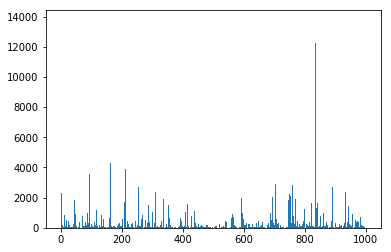

In [28]:
plt.hist(vals,bins =1000)
plt.show()

In [40]:
(np.nonzero(his[0]>1000))[0].shape

(102,)

In [12]:
select[0].shape

(46,)

In [13]:
def selecting(x,select):
    s = [i for i in x if i in (select[0])]
    return s

In [14]:
df4['select46_atts'] = df4['atts'].apply(lambda x: selecting(x,select))

In [15]:
df4.head()

,img_name,landmarks,atts,select46_atts
0,/Users/1024329/Downloads/DeepFashion/img_n/Lon...,"[[96, 2, 60, 60], [165, 2, 60, 60], [300, 153,...","[99, 495, 571, 881, 940]","[495, 571]"
1,/Users/1024329/Downloads/DeepFashion/img_n/Hoo...,"[[105, 5, 60, 60], [255, 3, 60, 60], [26, 195,...","[470, 953]",[470]
2,/Users/1024329/Downloads/DeepFashion/img_n/Rea...,"[[126, 36, 60, 60], [244, 42, 60, 60], [67, 3,...","[745, 883]","[745, 883]"
3,/Users/1024329/Downloads/DeepFashion/img_n/Flo...,"[[67, 8, 60, 60], [217, 2, 60, 60], [24, 167, ...","[142, 306, 365]","[142, 365]"
4,/Users/1024329/Downloads/DeepFashion/img_n/Bea...,"[[51, 68, 60, 60], [280, 80, 60, 60], [25, 13,...","[50, 121, 122, 226, 681]",[226]


In [16]:
# removing the samples without any attribute present in it
sample = df4['select46_atts'].apply(lambda x: np.array(x).shape[0]>0)
df5 =df4[sample]
df5.shape, df4.shape
# checking the maximum value of the attribute label
df5['select46_atts'].apply(lambda x: np.max(x)).max()

# reset index of df4
df5 = df5.reset_index(drop = True)

In [17]:
vals_new = np.array([])
for i in range(df5.shape[0]):
    if i %10000==0: print i
    vals_new = np.concatenate([vals_new,df5.loc[i,'select46_atts']]) 

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [18]:
# if i % 1000 ==0: print 'epoch and sample:', j, i
# X,X2,Y = get_batch(i)
# history = model_classifier.fit(x=[X,X2], y= Y)
# los = los + np.array(history.history['loss'])
# acc = acc + np.array(history.history['acc'])
        

In [19]:
df5['select46_atts'] = df5['select46_atts'].apply(lambda x: np.array(x))

In [20]:
def get_batch(i):
    a = cv2.imread(df4.loc[i,'img_name'])
    a = cv2.resize(a,(400,400))
    img = np.array(a).reshape(1,400,400,3)
    lnd = df4.loc[i,'landmarks']
    landmarks = (np.array(lnd)/8).astype(int).reshape(1,6,4)
    atts = df4.loc[i,'atts']
    labels = np.array([0 if k not in atts else 1 for k in range(1000)]).reshape(1,1000)
    return img, landmarks, labels

In [21]:
select[0]

array([  1,  93, 112, 142, 162, 181, 196, 207, 212, 226, 227, 254, 310,
       335, 365, 380, 441, 470, 495, 513, 546, 568, 571, 574, 577, 601,
       640, 695, 705, 720, 730, 745, 751, 754, 760, 818, 822, 836, 837,
       883, 884, 892, 935, 956, 983, 993])

In [22]:
def get_batch_new(num):
    #print num
    a = cv2.imread(df5.loc[num,'img_name'])
    a = cv2.resize(a,(400,400))
    img = np.array(a).reshape(1,400,400,3)
    lnd = df5.loc[num,'landmarks']
    landmarks = (np.array(lnd)/8).astype(int).reshape(1,6,4)
    atts = df5.loc[num,'select46_atts']
    labels = np.array([0 if item not in atts else 1 for item in select[0]]).reshape(1,46)
    return img/255, landmarks, labels

In [25]:
select[0]

array([  1,  93, 112, 142, 162, 181, 196, 207, 212, 226, 227, 254, 310,
       335, 365, 380, 441, 470, 495, 513, 546, 568, 571, 574, 577, 601,
       640, 695, 705, 720, 730, 745, 751, 754, 760, 818, 822, 836, 837,
       883, 884, 892, 935, 956, 983, 993])

In [81]:
train_loss = []
# train_acc = []
for j in range(20):
    print 'epoch number:', j
    los = 0
    acc = 0
    for i in range(2000):
        if i % 1000 ==0: print 'epoch and sample:', j, i
        X,X2,Y = get_batch_new(i)
        history = model_classifier.fit(x=[X,X2], y= Y, verbose = 2)
        los = los + np.array(history.history['loss'])
        #acc = acc + np.array(history.history['acc'])
        #print los
    train_loss.append(los)
    model_classifier.save_weights('atts_46model.h5')
    #train_acc.append(acc)
    #print train_loss, train_acc
        

epoch number: 0
epoch and sample: 0 0
Epoch 1/1
 - 26s - loss: 0.6931 - acc: 0.9565
Epoch 1/1
 - 11s - loss: 0.6926 - acc: 0.9348
Epoch 1/1
 - 12s - loss: 0.6921 - acc: 0.9130
Epoch 1/1
 - 10s - loss: 0.6916 - acc: 0.9130
Epoch 1/1
 - 11s - loss: 0.6903 - acc: 0.9783
Epoch 1/1
 - 13s - loss: 0.6898 - acc: 0.9783
Epoch 1/1
 - 9s - loss: 0.6894 - acc: 0.9130
Epoch 1/1
 - 9s - loss: 0.6883 - acc: 0.9565
Epoch 1/1
 - 9s - loss: 0.6879 - acc: 0.9565
Epoch 1/1
 - 9s - loss: 0.6859 - acc: 0.9565
epoch number: 1
epoch and sample: 1 0
Epoch 1/1
 - 9s - loss: 0.6857 - acc: 0.9565
Epoch 1/1
 - 9s - loss: 0.6828 - acc: 0.9783
Epoch 1/1
 - 9s - loss: 0.6817 - acc: 0.9565
Epoch 1/1
 - 10s - loss: 0.6789 - acc: 0.9565
Epoch 1/1
 - 9s - loss: 0.6756 - acc: 0.9783
Epoch 1/1
 - 8s - loss: 0.6763 - acc: 0.9783
Epoch 1/1
 - 9s - loss: 0.6751 - acc: 0.9130
Epoch 1/1
 - 9s - loss: 0.6689 - acc: 0.9565
Epoch 1/1
 - 9s - loss: 0.6701 - acc: 0.9565
Epoch 1/1
 - 11s - loss: 0.6628 - acc: 0.9565
epoch number: 2


In [93]:
xa,xb,ya = get_batch_new(10)
out_att = model_classifier.predict([xa,xb])

In [94]:
ya

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [95]:
print np.nonzero(ya>0), np.nonzero(out_att > 0.1)

(array([0]), array([30])) (array([0, 0, 0, 0]), array([ 9, 18, 22, 31]))


In [296]:
df5.head()

,img_name,landmarks,atts,select46_atts
0,/Users/1024329/Downloads/DeepFashion/img_n/Lon...,"[[96, 2, 60, 60], [165, 2, 60, 60], [300, 153,...","[99, 495, 571, 881, 940]","[495, 571]"
1,/Users/1024329/Downloads/DeepFashion/img_n/Hoo...,"[[105, 5, 60, 60], [255, 3, 60, 60], [26, 195,...","[470, 953]",[470]
2,/Users/1024329/Downloads/DeepFashion/img_n/Rea...,"[[126, 36, 60, 60], [244, 42, 60, 60], [67, 3,...","[745, 883]","[745, 883]"
3,/Users/1024329/Downloads/DeepFashion/img_n/Flo...,"[[67, 8, 60, 60], [217, 2, 60, 60], [24, 167, ...","[142, 306, 365]","[142, 365]"
4,/Users/1024329/Downloads/DeepFashion/img_n/Bea...,"[[51, 68, 60, 60], [280, 80, 60, 60], [25, 13,...","[50, 121, 122, 226, 681]",[226]


In [38]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
# model_classifier.fit(x = [X,X2],y= Y, batch_size=1, epochs=2,validation_split=0.2,callbacks = [checkpoint])